# Домашнее задание 3
## Модели ARIMA и GARCH

In [2]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
sales_of_company_x = pd.read_csv("/Users/ruslanpepa/Netology/Машинное обучение/Временные ряды/Знакомство с временными рядами/monthly-sales-of-company-x-jan-6.csv")

In [5]:
sales_of_company_x

,Month,Count
0,1965-01,154
1,1965-02,96
2,1965-03,73
3,1965-04,49
4,1965-05,36
...,...,...
72,1971-01,628
73,1971-02,308
74,1971-03,324
75,1971-04,248


In [6]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [7]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

## В чем суть

Будем представлять временной ряд $y_t$ в виде

$y_t = T + S + E$

где T - тренд, S - сезонная компонента, E - ошибка прогноза

Будем рассматривать разные "порождающие" модели для рядов. Интуитивно - если ряд хорошо описывается моделью, то остатки - независимые и одинаково распределенные

## Белый шум и случайные блуждания

Первая модель - которую мы рассмотрим - белый шум.

$y_t = E$

## Random Walk

### Следующая модель - это модель случайного блуждания.

$y_t = y_{t-1} + \epsilon_{t}$

где $\epsilon_{t}$ - белый шум
Особенность случайного блуждания в том, что он не стационарен, т.е. его свойства меняются со временем и предсказать его невозможно

## Практика - реализуйте процесс случайного блуждания

In [8]:
x = np.array(sales_of_company_x['Count'])

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


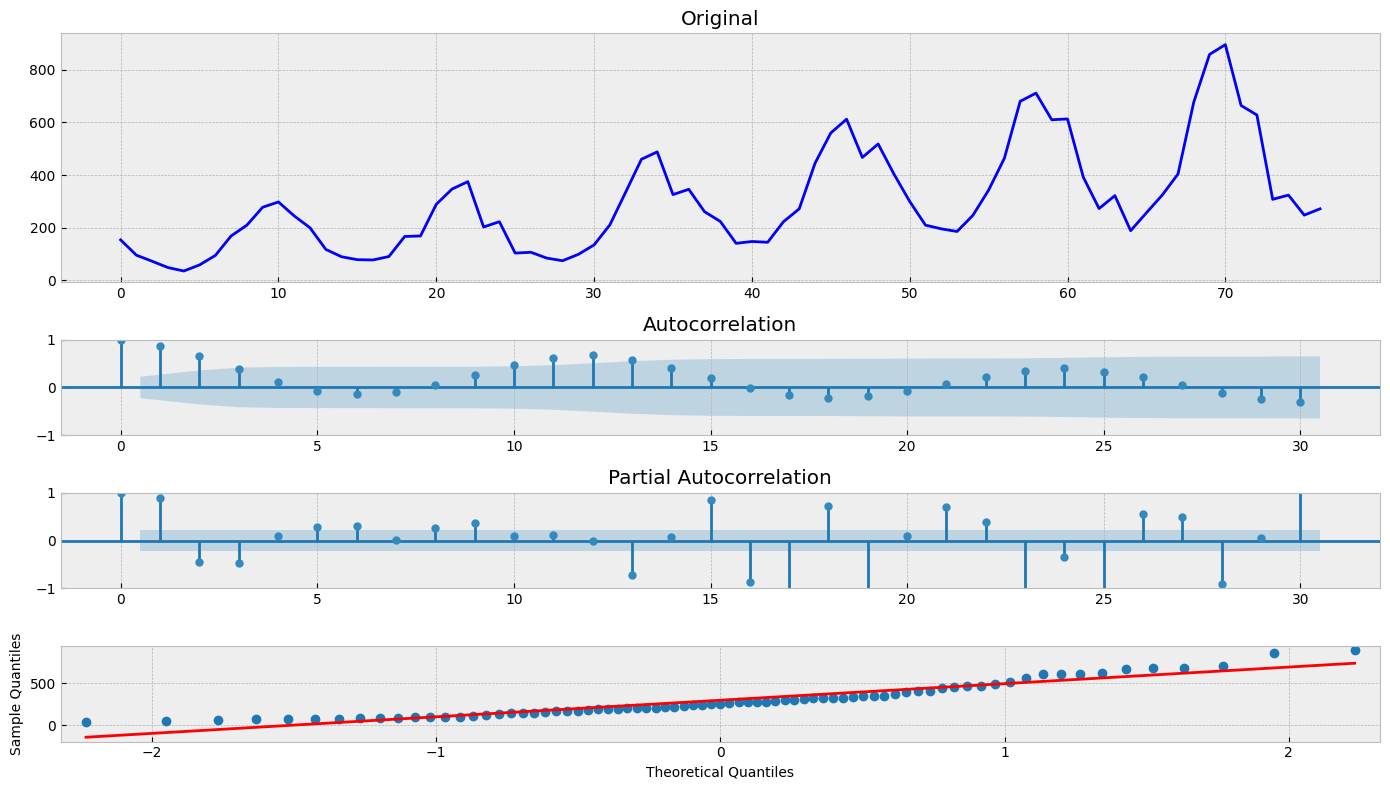

In [9]:
tsplot(x, lags=30)

Results of Dickey-Fuller Test:
Test Statistic                  -1.443664
p-value                          0.561173
#Lags Used                       0.000000
Number of Observations Used    999.000000
Critical Value (1%)             -3.436913
Critical Value (5%)             -2.864437
Critical Value (10%)            -2.568313
dtype: float64


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


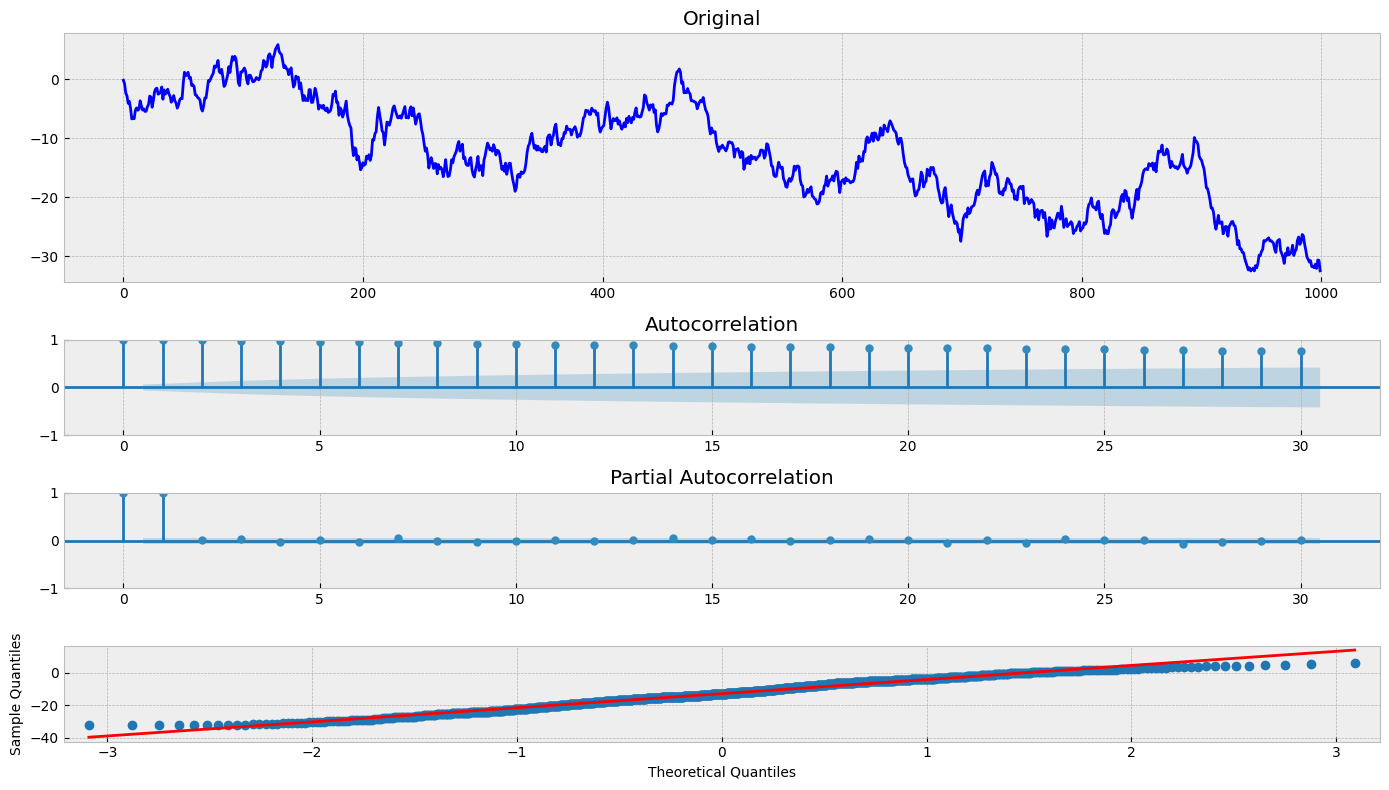

In [10]:
x = np.random.normal(size=1000)
x = np.cumsum(x)
tsplot(x, lags=30)

Давайте проверим, подходит ли модель случайного блуждания под сгенерированные данные. Для этого надо из текущего измерения вычесть предыдущие и посмотреть остатки

Results of Dickey-Fuller Test:
Test Statistic                -7.891662e+00
p-value                        4.419796e-12
#Lags Used                     1.000000e+01
Number of Observations Used    9.880000e+02
Critical Value (1%)           -3.436986e+00
Critical Value (5%)           -2.864470e+00
Critical Value (10%)          -2.568330e+00
dtype: float64


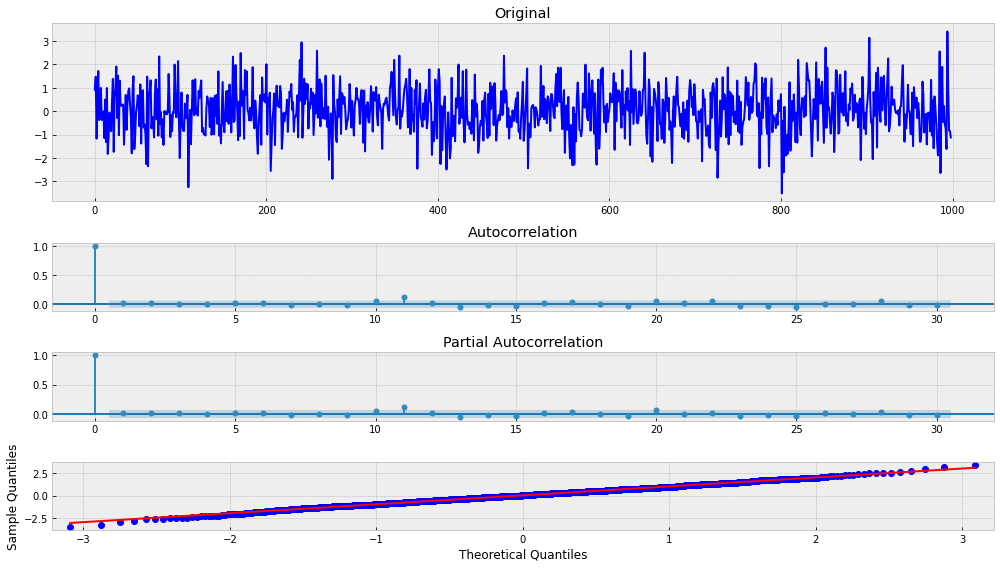

In [13]:
tsplot(np.diff(x), lags=30)

Ура! Однако для реальных данных такой модели конечно не достаточно.

# AR(p)

Сделаем симуляцию процесса AR(1) и посмотрим, сумеет ли модель AR правильно подобрать коэффициенты

In [48]:
from statsmodels.tsa.arima_model import ARIMA

In [42]:
from statsmodels.tsa.ar_model import AutoReg

In [59]:
mdl = AutoReg(x, lags=[1, 11, 12], seasonal=True, period=30).fit()
# mdl = smt.AR(x).fit(maxlag=30, ic='aic', trend='nc')
est_order = AutoReg(x, lags=[1, 11, 12], seasonal=True, period=30).fit()
# est_order = smt.AR(x).select_order(maxlag=30, ic='aic', trend='nc')

true_order = 1
print('\nalpha estimate: {:3.5f}'.format(mdl.params[0]))



alpha estimate: -0.42209


In [60]:
mdl.params[0]

-0.4220902711164678

Results of Dickey-Fuller Test:
Test Statistic                 -30.596761
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    987.000000
Critical Value (1%)             -3.436993
Critical Value (5%)             -2.864473
Critical Value (10%)            -2.568332
dtype: float64


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


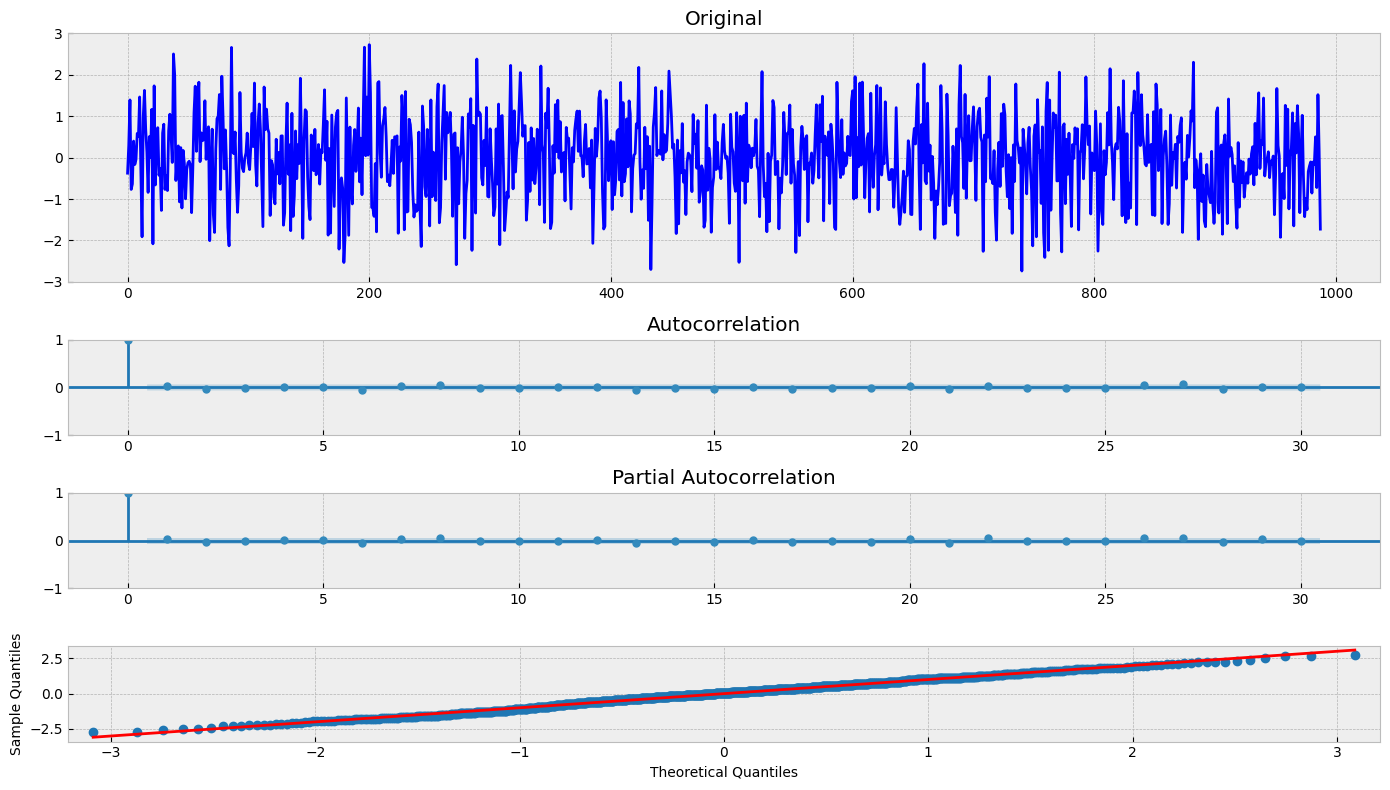

In [55]:
tsplot(mdl.resid, lags=30)

## Практика - сделайте симуляцию процесса AR(2) с параметрами 0.6 и 0.3 и посмотрите, сумеет ли модель AR правильно подобрать коэффициенты

Results of Dickey-Fuller Test:
Test Statistic                  -1.443664
p-value                          0.561173
#Lags Used                       0.000000
Number of Observations Used    999.000000
Critical Value (1%)             -3.436913
Critical Value (5%)             -2.864437
Critical Value (10%)            -2.568313
dtype: float64


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


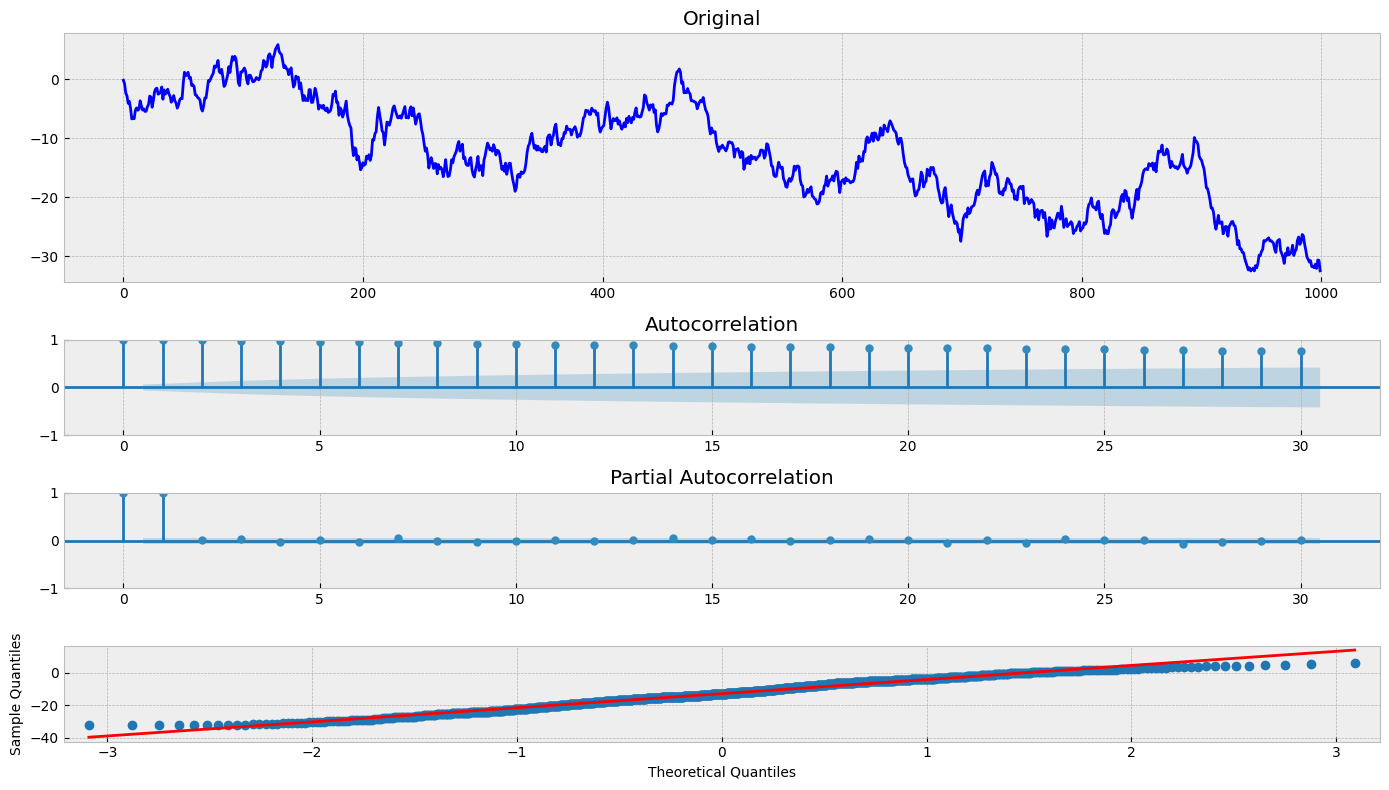

In [56]:
tsplot(x, lags=30)

In [62]:
mdl = AutoReg(x, lags=[3], trend='c').fit()
# mdl = smt.AR(x).fit(maxlag=3, trend='nc')

print('\nalpha estimate: {}'.format(mdl.params))


alpha estimate: [-0.30682326  0.9831141 ]


Results of Dickey-Fuller Test:
Test Statistic                -6.670389e+00
p-value                        4.603651e-09
#Lags Used                     2.200000e+01
Number of Observations Used    9.740000e+02
Critical Value (1%)           -3.437082e+00
Critical Value (5%)           -2.864512e+00
Critical Value (10%)          -2.568352e+00
dtype: float64


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


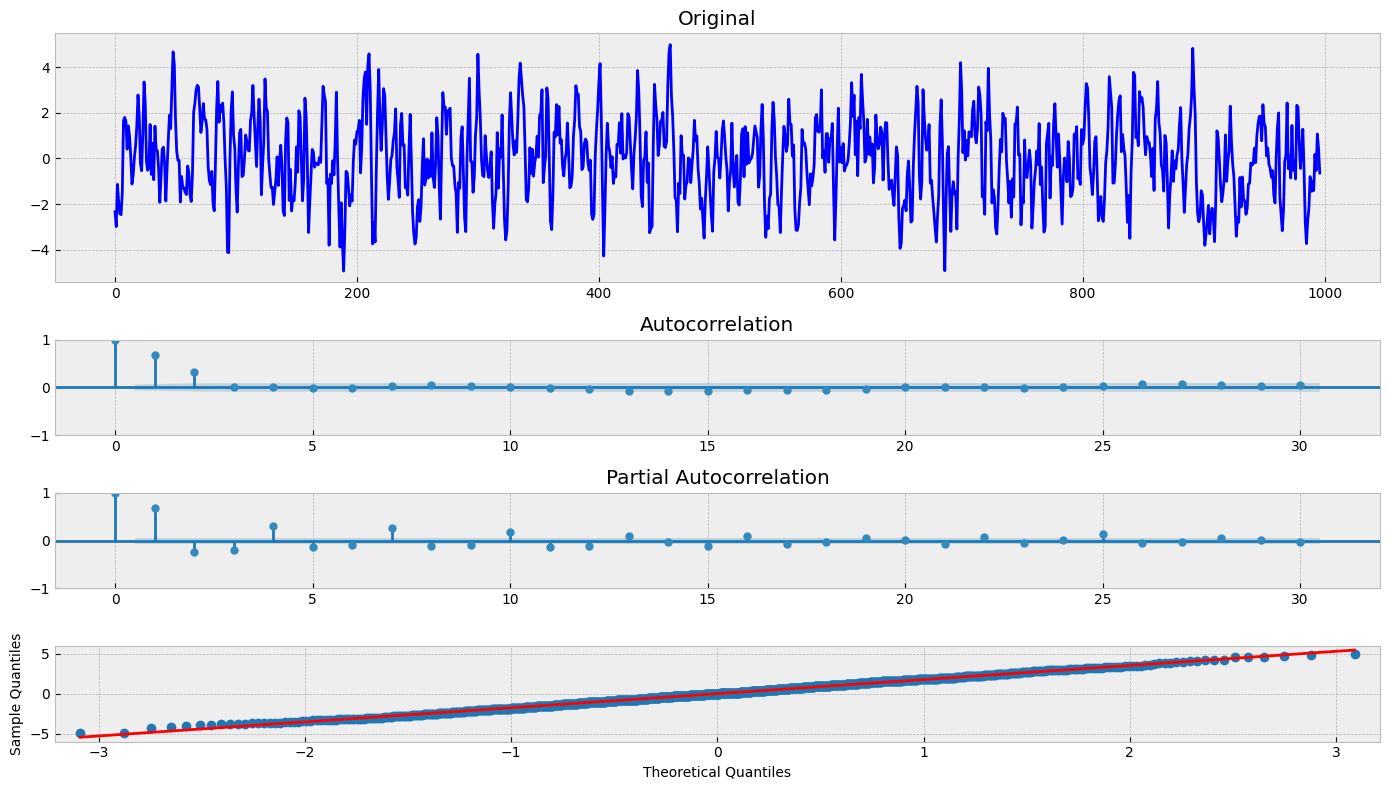

In [63]:
tsplot(mdl.resid, lags=30)

## MA(q)
В настоящий момент будем говорить про модель MA(q) - как про модель авторегресии на случайном шуме

$y_t = \sum_{j=0}^{Q} b_j \epsilon_{t-j}$

## ARMA(p,q)

Модель ARMA(p, q) представляет собой соединение двух моделей:
- AR(P) - авторегрессии на знанениях временного ряда
- MA(q) - авторегрессии на ошибках первой

AR(p) пытается предсказать "значение" временного ряда, а MA(q) пытается поймать шоковые явления, наблюдаемые в оставшемся случайном шуме.

$y_t = \sum_{i=1}^P a_i x_{t-i} + \sum_{i=1}^Q b_i \epsilon_{t-i} + \epsilon_t + c$

Сделаем симуляцию процесса ARMA